# Universidad de Buenos Aires
# IAR - TP FINAL



In [348]:
import pandas as pd
import numpy as np
from scipy import stats
import math
import datetime
import cv2 as cv
import pickle as pkl
import copy
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Conv2D, TimeDistributed, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20
plt.rcParams["axes.grid"] =True

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Mapa

### Clase Mapa

Contiene todas las utilidades relacionadas a la geolocalización y a la transformación a plano de imágen

In [126]:
class my_map:
    
    color_map = None
    policy = None
    pos_to_coord = None
    coord_to_pos = None
    
    def __init__(self, path_to_map, path_to_policy=None):
        self.color_map = cv.imread(path_to_map)
        self.color_map = cv.cvtColor(self.color_map, cv.COLOR_BGR2RGB)
        if path_to_policy is None:
            self.policy = np.ones(shape=self.map.shape())*255
        else:
            self.policy = cv.imread(path_to_policy,cv.IMREAD_GRAYSCALE)
        
        pass
    
    
    def calibrate(self, calib_coord, calib_bmp):
        self.coord_to_pos = LinearRegression()
        self.coord_to_pos.fit(calib_coord,calib_bmp)
        self.pos_to_coord = LinearRegression()
        self.pos_to_coord.fit(calib_bmp,calib_coord)
    
    
    def to_coord(self, bmp_pos):
        if self.pos_to_coord is not None:
            return self.pos_to_coord.predict(bmp_pos)
        else:
            return None
    
    
    def to_pos(self, coord):
        if self.coord_to_pos is not None:
            return np.round(self.coord_to_pos.predict(coord)).astype(int)
        else:
            return None
    
    
    def plot(self, coord, file=None):
        pos = self.to_pos(coord)
        fig = plt.figure(figsize=(40,20))
        plt.grid(False)
        plt.imshow(self.color_map)
        if pos is not None:
            for point in pos:
                plt.scatter(point[1], point[0], c='red', s=15)
        plt.show()
        if file is not None:
            fig.savefig(file, bbox_inches='tight')
        
    
    def plot_policy(self):
        plt.figure(figsize=(40,20))
        plt.grid(False)
        plt.imshow(self.policy)
        plt.show()
        
    
    def get_policy_prob (self,coords):
        points = self.to_pos(coords)
        prob = np.zeros(points.shape[0])
        for i,point in enumerate(points):
            if ((point[0]<0) or (point[0]>=self.policy.shape[0]) or (point[1]<0) or (point[1]>=self.policy.shape[1])):
                prob[i] = self.policy[0,0] * 0
            else:
                prob[i] = self.policy[point[0],point[1]] / 255
        
        return prob
    
    @staticmethod
    def destinationPoint(lat, lon, distance, bearing):
        '''
        Returns the destination point from a given point, having travelled the given distance
        on the given initial bearing.

        @param   {number} lat - initial latitude in decimal degrees (eg. 50.123)
        @param   {number} lon - initial longitude in decimal degrees (e.g. -4.321)
        @param   {number} distance - Distance travelled (metres).
        @param   {number} bearing - Initial bearing (in degrees from north).
        @returns {array} destination point as [latitude,longitude] (e.g. [50.123, -4.321])

        @example
        var p = destinationPoint(51.4778, -0.0015, 7794, 300.7); // 51.5135°N, 000.0983°W
        '''
        radius = 6371e3; # (Mean) radius of earth
        
        def toRadians(v):
            return v * math.pi / 180
        
        def toDegrees(v):
            return v * 180 / math.pi


        delta = distance / radius; # angular distance in radians
        theta = toRadians(bearing);

        phi_1 = toRadians(lat);
        lambda_1 = toRadians(lon);
        
        sin_phi_1 = math.sin(phi_1) 
        cos_phi_1 = math.cos(phi_1)
        sin_delta = math.sin(delta)
        cos_delta = math.cos(delta)
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)

        sin_phi_2 = sin_phi_1* cos_delta + cos_phi_1 * sin_delta * cos_theta
        phi_2 = math.asin(sin_phi_2)
        y = sin_theta * sin_delta * cos_phi_1
        x = cos_delta - sin_phi_1 * sin_phi_2
        lambda_2 = lambda_1 + math.atan2(y, x)
        
        lat2 = toDegrees(phi_2)
        
        lon2 = (toDegrees(lambda_2) + 540) % 360 - 180 # normalise to −180..+180°

        return lat2,lon2
    
    @staticmethod
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance in meters between two points 
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians 
        lon1 = math.radians (lon1)
        lat1 = math.radians (lat1)
        lon2 =  math.radians (lon2)
        lat2 =  math.radians (lat2)

        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a)) 
        r = 6371 * 1000 # Radius of earth in meters.
        return c * r 

### Carga de imagen y mascara de calles

In [127]:
rosario_map_path = 'map/raw.png'
rosario_policy_path = 'map/Rosario_compress_blur.bmp'

work_map = my_map(rosario_map_path,rosario_policy_path)

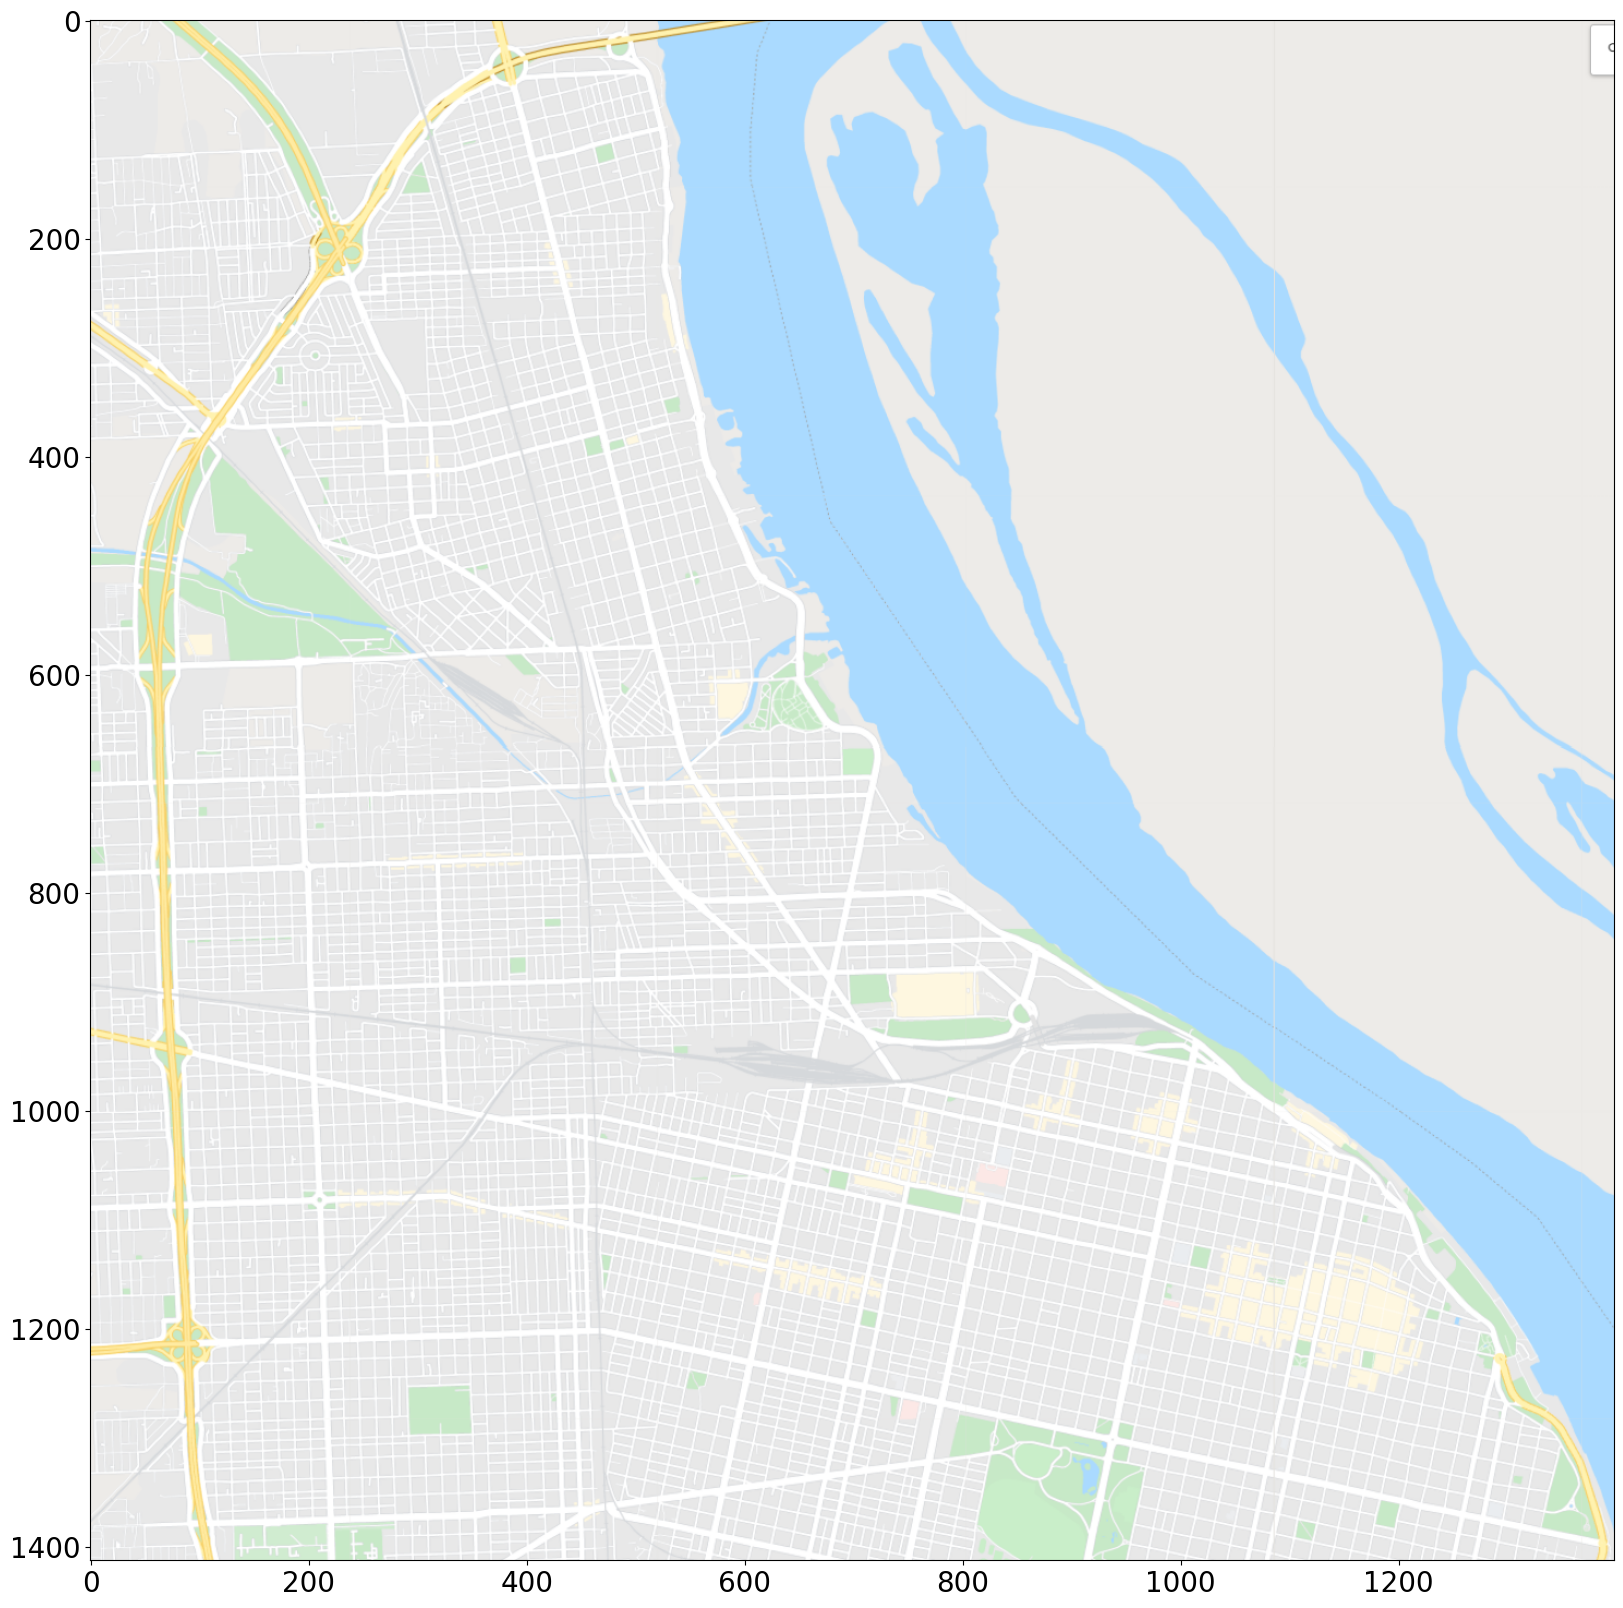

In [128]:
work_map.plot(None)

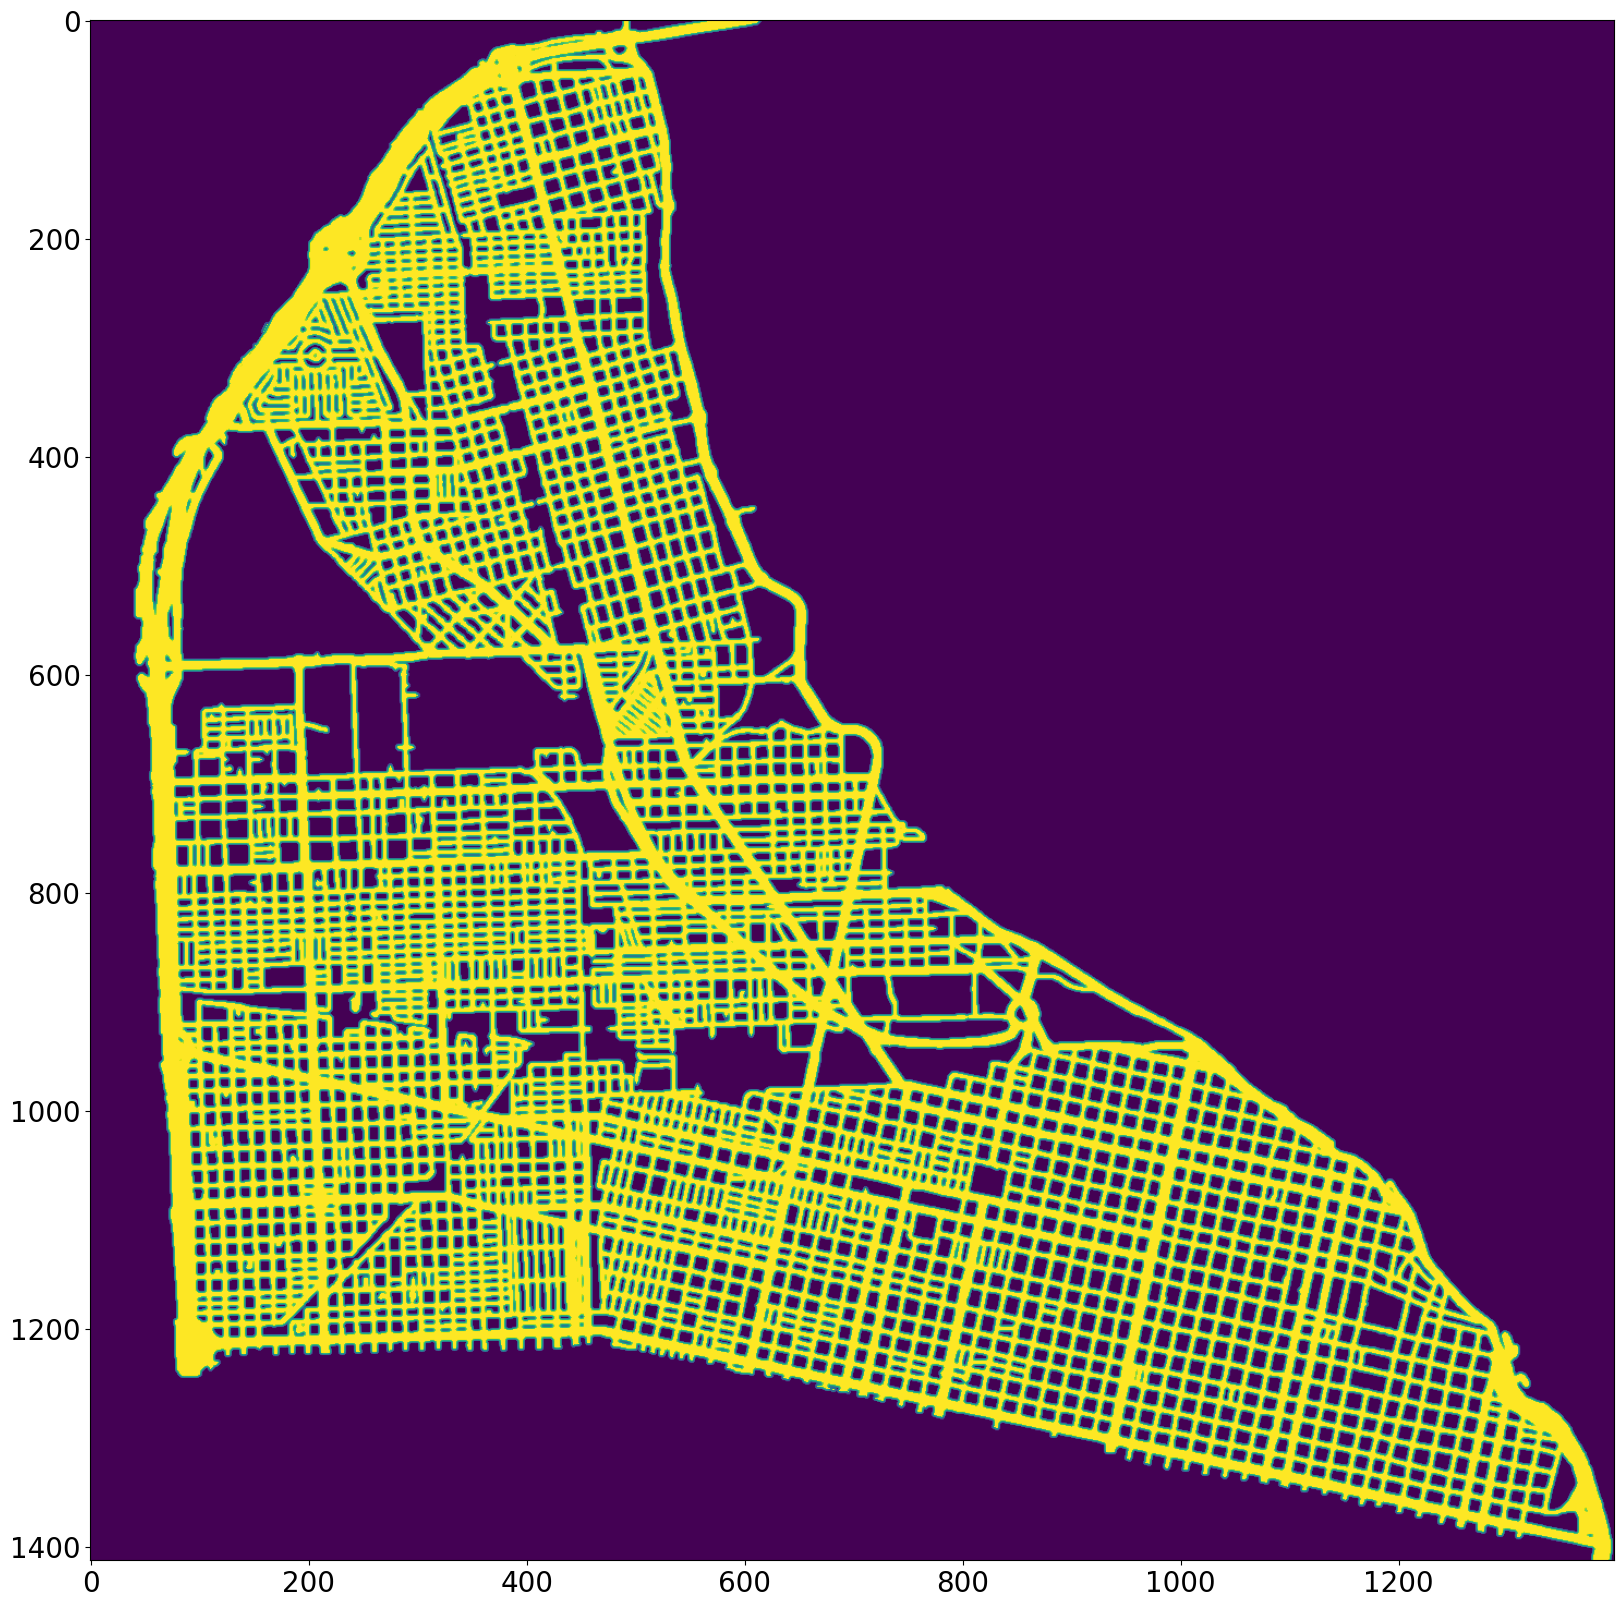

In [129]:
work_map.plot_policy()

## Calibracion

In [130]:
# Puntos de calibración Mapa - BMP
# 1: Alem y Pellegrini
# 2: Pellegrini y Provincias unidas
# 3: Rondeau y Pintor Musto
# 4: Francia y Luis Candido Carballo

calib_coord = [ #[ Latitude , Longitude ]
                [ -32.95907 , -60.63112],
                [ -32.9486 , -60.71226],
                [ -32.87341 , -60.69889],
                [ -32.92526 , -60.66143]
              ]

calib_bmp = [   #[height, width]
                [ 1370 , 1258],
                [ 1212 , 215],
                [ 56, 386],
                [ 853, 867]
            ]

In [131]:
work_map.calibrate(calib_coord,calib_bmp)

In [132]:
# Test con datos de entrenamiento
print(work_map.to_pos([[ -32.87341 , -60.69889]]))
print(work_map.to_coord([[56,386]]))

[[ 56 386]]
[[-32.87338416 -60.69886842]]


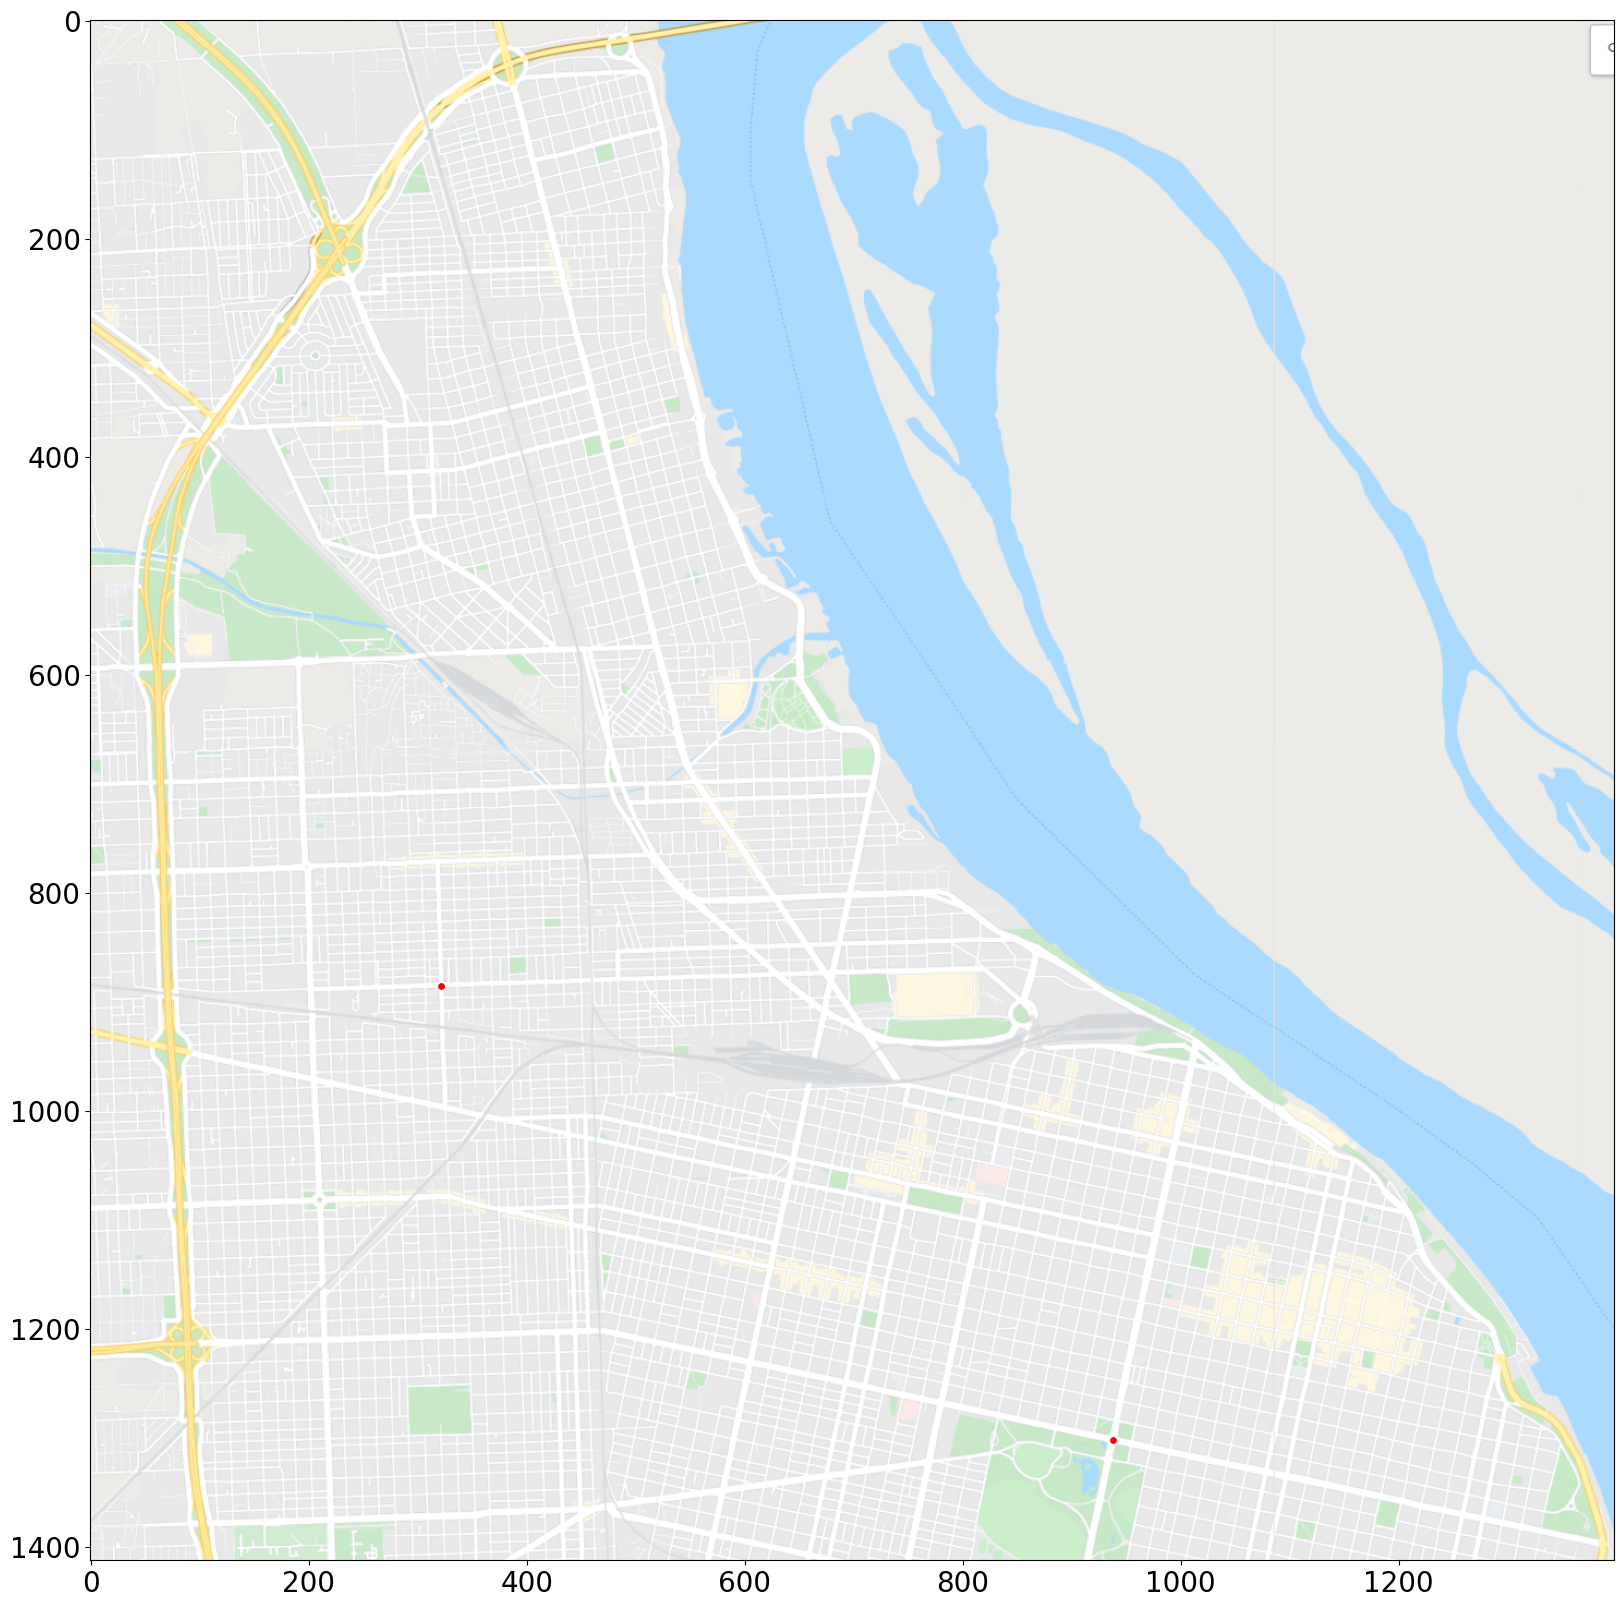

In [133]:
# Test con nuevos datos
# 1: Oroño y Pellegrini
# 2: Solis y Junin
work_map.plot([[ -32.95459 , -60.65599], [ -32.92738 , -60.70398]])

## Dataset de ruta

### Carga y preprocesamiento

Cargamos el dataset de la ruta trazada y lo inspeccionamos

In [473]:
route_1_path = "data/processed/SensorTracker_20211011_175124.csv"
route_1 = pd.read_csv(route_1_path, sep=";")

In [474]:
route_1.head()

Timestamp  Accel_x  Accel_y  Accel_z  Gyro_x  Gyro_y  Gyro_z  \
0  20211011_175802.0   -0.348   -1.021    9.815  -0.003  -0.013   0.004   
1  20211011_175802.5   -0.255   -0.762    9.657   0.005   0.007   0.005   
2  20211011_175803.0    0.049   -0.755   10.256  -0.005   0.028  -0.001   
3  20211011_175803.5   -0.111   -1.522   10.292  -0.027   0.020   0.007   
4  20211011_175804.0   -0.499   -1.013    9.925  -0.023  -0.014  -0.005   

   Light  Magnetic_x  Magnetic_y  Magnetic_z  Proximity  Latitude  Longitude  \
0  410.5     -47.831      18.263     -58.669        5.0 -32.95812  -60.63654   
1  410.5     -48.394      17.963     -57.263        5.0 -32.95813  -60.63644   
2  410.5     -48.469      15.900     -60.525        5.0 -32.95813  -60.63644   
3  410.5     -48.975      18.281     -59.419        5.0 -32.95815  -60.63635   
4  410.5     -48.975      18.281     -59.419        5.0 -32.95815  -60.63635   

   Elevation  Speed  
0       52.8   29.1  
1       53.6   30.1  
2       53.6   30.1  
3       51.9   30.1  
4       51.9   30.1

El dataset necesita tratamiento previo:

- Corregir el datetime con milisegundos a un formato correcto de timestamp.
- Convertir velocidad de km/h a m/s
- Dado que algunos sensores se actualizan realmente a 1 segundo en lugar de 500 ms, resampleamos a 1 segundo.

In [475]:
# Correct timestamp
route_1['Timestamp'] = route_1['Timestamp'].map(lambda x: datetime.datetime.\
                                                            strptime(x, "%Y%m%d_%H%M%S.%f").timestamp(), \
                                                na_action='ignore')
# Speed to m/s
route_1['Speed'] = route_1['Speed'].map(lambda x: x/3.6)

# Rename column
route_1['Acceleration'] = route_1['Accel_y']

# Resample to 1s
route_1 = route_1.loc[route_1['Timestamp']%1==0]

# Reset Index
route_1 = route_1.reset_index()

En el dataset falta el angulo de movimiento respecto al norte. Este valor se debería poder obtener a partir del acelerómetro, giróscopo y sensor magnético, pero requieren de una calibración previa. Dado que esta calibración no fue realizada, que los sensores del celular utilizado son de baja calidad y que la fórmula es compleja, se decidió obtener el ángulo de rumbo en forma artificial con los datos del GPS.

En forma similar, para la velocidad se utilizó el sensor de GPS.

In [480]:
def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)

    return brng

In [481]:
route_1['Bearing'] = route_1['Timestamp'].map(lambda x:0)

for i in range(route_1.shape[0]-1):
    route_1['Bearing'].iloc[i] = get_bearing( route_1['Latitude'].iloc[i],
                                             route_1['Longitude'].iloc[i],
                                             route_1['Latitude'].iloc[i+1],
                                             route_1['Longitude'].iloc[i+1]
                                           )
route_1['Bearing'].iloc[-1] =  route_1['Bearing'].iloc[-2]

C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [455]:
route_1['Bearing'] = np.convolve(route_1['Bearing'], np.ones(N)/N, mode='same')

In [456]:
N=10
np.convolve(route_1['Bearing'], np.ones(N)/N, mode='valid')

array([ 77.62979646,  78.41962722,  77.80830353, ..., 159.68391966,
       154.72207537, 148.05736747])

In [457]:
class DeepModel(object):

    def fit(self, X, y):
        
        inputs = Input(shape=(5,9))
        x = Bidirectional(LSTM(units=64, return_sequences=True))(inputs)
        x = Bidirectional(LSTM(units=64))(x)
        x = Dense(units=1000, activation="tanh")(x)
        x = Dense(units=1000, activation="tanh")(x)
        x = Dense(units=1, activation="linear")(x)
        self.model = Model(inputs, x)
        
        self.model.compile(optimizer=Adam(), loss='mse')
        self.model.summary()

        history=self.model.fit(X, y, epochs=500, batch_size=128, shuffle=True, validation_split=0.2)

        return history
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [478]:
timestep = 5
model_input=np.zeros(shape=(route_1.shape[0],timestep,9))
for i in range(route_1.shape[0]):
    if i<timestep:
        for j in range(0,timestep-(i+1)):
            model_input[i,j,:]=np.array(route_1[['Accel_x','Accel_y','Accel_z','Gyro_x',
                                                'Gyro_y','Gyro_z','Magnetic_x','Magnetic_y','Magnetic_z']].iloc[0])
        for j in range(timestep-(i+1),timestep):
            model_input[i,j,:]=np.array(route_1[['Accel_x','Accel_y','Accel_z','Gyro_x',
                                                'Gyro_y','Gyro_z','Magnetic_x','Magnetic_y','Magnetic_z']].iloc[j-(timestep-(i+1))])
            
    else:
        for j in range(0,timestep):
            model_input[i,j,:]=np.array(route_1[['Accel_x','Accel_y','Accel_z','Gyro_x',
                                                'Gyro_y','Gyro_z','Magnetic_x','Magnetic_y','Magnetic_z']].iloc[i-timestep+j+1])
            
    

In [477]:
timestep = 5
model_input=np.zeros(shape=(route_1.shape[0],timestep,9))
for i in range(route_1.shape[0]):
    if i<timestep:
        for j in range(0,timestep-(i+1)):
            model_input[i,j,:]=np.array(route_1[['Accel_x','Accel_y','Accel_z','Gyro_x',
                                                'Gyro_y','Gyro_z','Magnetic_x','Magnetic_y','Magnetic_z']].iloc[0])
        for j in range(timestep-(i+1),timestep):
            model_input[i,j,:]=np.array(route_1[['Accel_x','Accel_y','Accel_z','Gyro_x',
                                                'Gyro_y','Gyro_z','Magnetic_x','Magnetic_y','Magnetic_z']].iloc[j-(timestep-(i+1))])
            
    else:
        for j in range(0,timestep):
            model_input[i,j,:]=np.array(route_1[['Accel_x','Accel_y','Accel_z','Gyro_x',
                                                'Gyro_y','Gyro_z','Magnetic_x','Magnetic_y','Magnetic_z']].iloc[i-timestep+j+1])
            
    
    
shuffle_idx = np.random.permutation(model_input.shape[0])
model_input_shuffle  = model_input[shuffle_idx,:,:]
model_output_shuffle = np.array(route_1['Bearing'])[shuffle_idx]

KeyError: 'Bearing'

In [459]:
model = DeepModel()

history=model.fit(model_input_shuffle,
                  model_output_shuffle)

Model: "functional_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 5, 9)]            0         
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 5, 128)            37888     
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_110 (Dense)            (None, 1000)              129000    
_________________________________________________________________
dense_111 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 1001      
Total params: 1,267,705
Trainable params: 1,267,705
Non-trainable params: 0
___________________________________________

20/20 [==============================] - 0s 11ms/step - loss: 206.1397 - val_loss: 248.1114
Epoch 69/500
20/20 [==============================] - 0s 11ms/step - loss: 191.1011 - val_loss: 232.7312
Epoch 70/500
20/20 [==============================] - 0s 11ms/step - loss: 198.5356 - val_loss: 238.4397
Epoch 71/500
20/20 [==============================] - 0s 11ms/step - loss: 190.1379 - val_loss: 259.1551
Epoch 72/500
20/20 [==============================] - 0s 11ms/step - loss: 194.4006 - val_loss: 215.6115
Epoch 73/500
20/20 [==============================] - 0s 11ms/step - loss: 213.4517 - val_loss: 233.1568
Epoch 74/500
20/20 [==============================] - 0s 11ms/step - loss: 205.8622 - val_loss: 243.0312
Epoch 75/500
20/20 [==============================] - 0s 11ms/step - loss: 186.8999 - val_loss: 238.0657
Epoch 76/500
20/20 [==============================] - 0s 11ms/step - loss: 198.4990 - val_loss: 252.0701
Epoch 77/500
20/20 [==============================] - 0s 11ms/step -

20/20 [==============================] - 0s 11ms/step - loss: 135.5267 - val_loss: 160.1865
Epoch 146/500
20/20 [==============================] - 0s 10ms/step - loss: 119.8351 - val_loss: 180.2047
Epoch 147/500
20/20 [==============================] - 0s 10ms/step - loss: 120.7774 - val_loss: 185.0850
Epoch 148/500
20/20 [==============================] - 0s 11ms/step - loss: 110.9043 - val_loss: 171.2822
Epoch 149/500
20/20 [==============================] - 0s 11ms/step - loss: 114.4727 - val_loss: 154.4974
Epoch 150/500
20/20 [==============================] - 0s 11ms/step - loss: 101.0915 - val_loss: 147.9274
Epoch 151/500
20/20 [==============================] - 0s 11ms/step - loss: 115.8247 - val_loss: 170.5291
Epoch 152/500
20/20 [==============================] - 0s 11ms/step - loss: 122.3480 - val_loss: 171.5564
Epoch 153/500
20/20 [==============================] - 0s 10ms/step - loss: 120.7199 - val_loss: 147.1351
Epoch 154/500
20/20 [==============================] - 0s 10

Epoch 223/500
20/20 [==============================] - 0s 11ms/step - loss: 70.3275 - val_loss: 163.2750
Epoch 224/500
20/20 [==============================] - 0s 11ms/step - loss: 73.2201 - val_loss: 129.3020
Epoch 225/500
20/20 [==============================] - 0s 10ms/step - loss: 72.9258 - val_loss: 156.9395
Epoch 226/500
20/20 [==============================] - 0s 10ms/step - loss: 70.0983 - val_loss: 135.4413
Epoch 227/500
20/20 [==============================] - 0s 10ms/step - loss: 65.2325 - val_loss: 126.7489
Epoch 228/500
20/20 [==============================] - 0s 11ms/step - loss: 63.8045 - val_loss: 129.4936
Epoch 229/500
20/20 [==============================] - 0s 11ms/step - loss: 65.6496 - val_loss: 142.1430
Epoch 230/500
20/20 [==============================] - 0s 10ms/step - loss: 62.8060 - val_loss: 141.6165
Epoch 231/500
20/20 [==============================] - 0s 11ms/step - loss: 68.0526 - val_loss: 140.5031
Epoch 232/500
20/20 [==============================] - 

20/20 [==============================] - 0s 11ms/step - loss: 47.7580 - val_loss: 114.3521
Epoch 302/500
20/20 [==============================] - 0s 11ms/step - loss: 57.9660 - val_loss: 133.5496
Epoch 303/500
20/20 [==============================] - 0s 11ms/step - loss: 55.4826 - val_loss: 104.2734
Epoch 304/500
20/20 [==============================] - 0s 11ms/step - loss: 50.7138 - val_loss: 128.6633
Epoch 305/500
20/20 [==============================] - 0s 11ms/step - loss: 46.2829 - val_loss: 127.0061
Epoch 306/500
20/20 [==============================] - 0s 10ms/step - loss: 44.7876 - val_loss: 107.0264
Epoch 307/500
20/20 [==============================] - 0s 11ms/step - loss: 42.7439 - val_loss: 120.3060
Epoch 308/500
20/20 [==============================] - 0s 11ms/step - loss: 41.7468 - val_loss: 115.7940
Epoch 309/500
20/20 [==============================] - 0s 10ms/step - loss: 40.5968 - val_loss: 98.1702
Epoch 310/500
20/20 [==============================] - 0s 11ms/step - 

20/20 [==============================] - 0s 11ms/step - loss: 34.0810 - val_loss: 108.3016
Epoch 380/500
20/20 [==============================] - 0s 11ms/step - loss: 32.5635 - val_loss: 103.3334
Epoch 381/500
20/20 [==============================] - 0s 11ms/step - loss: 34.3208 - val_loss: 125.5620
Epoch 382/500
20/20 [==============================] - 0s 11ms/step - loss: 30.7300 - val_loss: 110.9614
Epoch 383/500
20/20 [==============================] - 0s 11ms/step - loss: 31.5969 - val_loss: 110.9457
Epoch 384/500
20/20 [==============================] - 0s 11ms/step - loss: 33.9016 - val_loss: 121.3009
Epoch 385/500
20/20 [==============================] - 0s 11ms/step - loss: 34.8385 - val_loss: 123.6638
Epoch 386/500
20/20 [==============================] - 0s 11ms/step - loss: 34.5125 - val_loss: 111.0938
Epoch 387/500
20/20 [==============================] - 0s 10ms/step - loss: 32.8199 - val_loss: 116.1003
Epoch 388/500
20/20 [==============================] - 0s 11ms/step -

20/20 [==============================] - 0s 10ms/step - loss: 27.0659 - val_loss: 102.4733
Epoch 458/500
20/20 [==============================] - 0s 11ms/step - loss: 27.4999 - val_loss: 109.1095
Epoch 459/500
20/20 [==============================] - 0s 11ms/step - loss: 24.7935 - val_loss: 100.9218
Epoch 460/500
20/20 [==============================] - 0s 10ms/step - loss: 23.7487 - val_loss: 101.6232
Epoch 461/500
20/20 [==============================] - 0s 11ms/step - loss: 21.3625 - val_loss: 102.3978
Epoch 462/500
20/20 [==============================] - 0s 11ms/step - loss: 26.0282 - val_loss: 111.4650
Epoch 463/500
20/20 [==============================] - 0s 11ms/step - loss: 28.1982 - val_loss: 108.8930
Epoch 464/500
20/20 [==============================] - 0s 11ms/step - loss: 26.4688 - val_loss: 98.3447
Epoch 465/500
20/20 [==============================] - 0s 11ms/step - loss: 24.0607 - val_loss: 103.7409
Epoch 466/500
20/20 [==============================] - 0s 11ms/step - 

In [487]:
model.model.predict(model_input)

array([[ 86.32366 ],
       [ 61.604633],
       [ 30.706583],
       ...,
       [135.70308 ],
       [122.70732 ],
       [101.03117 ]], dtype=float32)

<Figure size 2000x900 with 0 Axes>

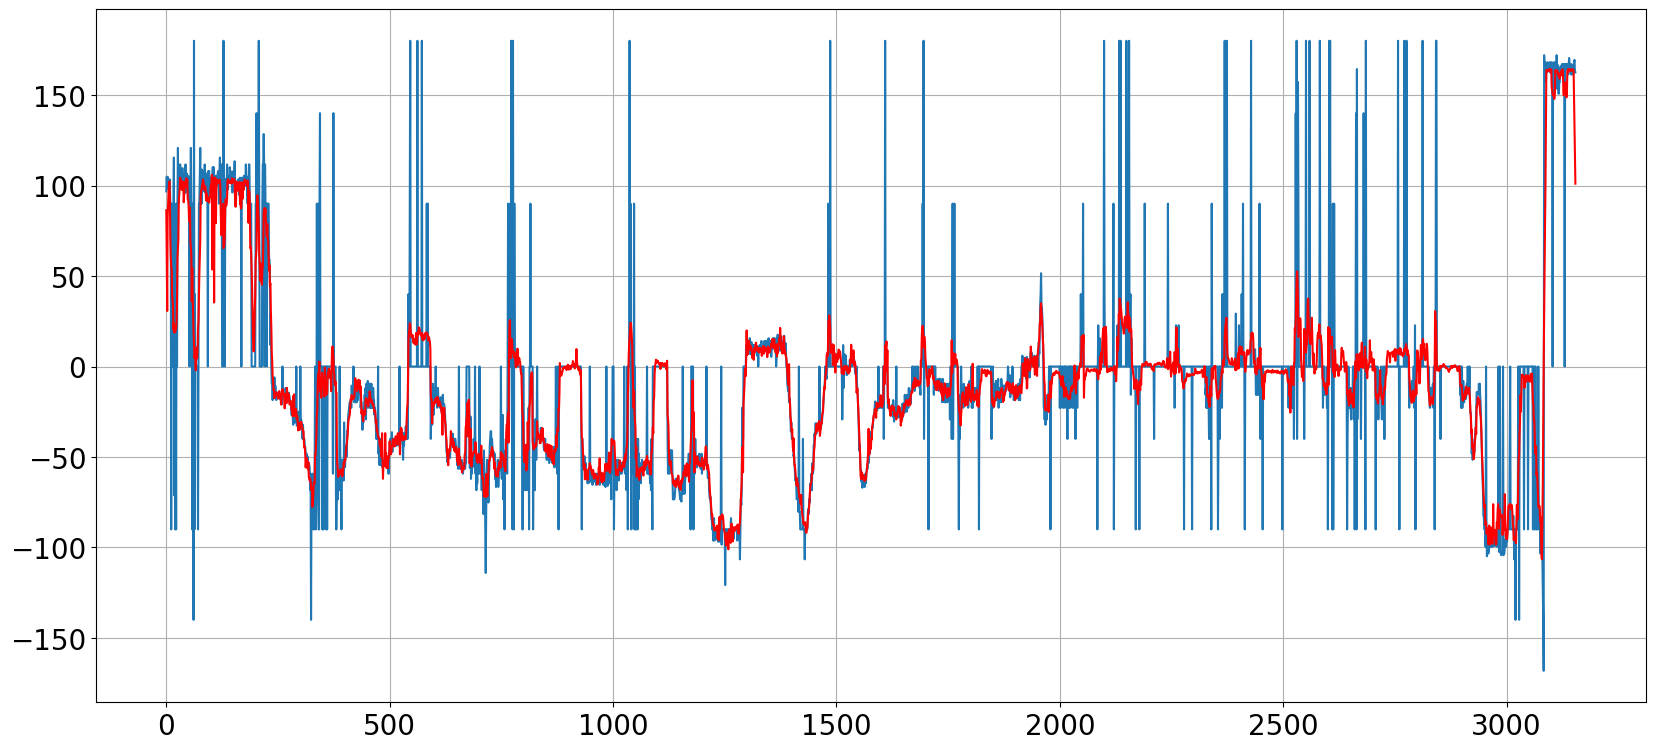

In [482]:
plt.figure()
plt.plot(route_1['Bearing'])
plt.plot(model.model.predict(model_input), c='red')
plt.show()

In [461]:
route_1['Bearing']=model.model.predict(model_input)

In [485]:
model.model.save_weights('bearing_model/bearing_model.h5')

In [486]:
with open('bearing_model/bearing_model_config.json', 'w') as json_file:
    json_file.write(model.model.to_json())

In [462]:
class my_car():
    
    def __init__(self):
        self.lat = 0.0
        self.lon = 0.0
        self.movement_noise = 0
        self.speed_noise = 0
        self.acceleration_noise = 0
        self.bearing_noise = 0
        
        self.x = np.array([[0.], [0.], [0.], [0.], [0.]]) # estado inicial (distancia, velocidad, aceleracion, bearing, tasa cambio bearing)
        
        self.P = np.array([[10., 0., 0., 0., 0.],
                          [0., 5., 0., 0., 0.],
                          [0., 0., 1., 0., 0.],
                          [0., 0., 0., 10., 0.],
                          [0., 0., 0., 0., 1.]]) # Incertidumbre inicial
        
        self.F = np.array([[1., 1., 0., 0., 0.],
                      [0., 1., 0., 0., 0.],
                      [0., 0., 1., 0., 0.],
                      [0., 0., 0., 1., 1.],
                      [0., 0., 0., 0., 1.]]) # matriz de estados
        
        self.H = np.array([[0., 1., 0., 0., 0.],
                     [0., 0., 1., 0., 0.],
                     [0., 0., 0., 1., 0.]]) # matriz de mediciones
        
        self.R = np.array([[1., 0., 0.],
                          [0, 0.04, 0.],
                          [ 0., 0., 5.]]) # incertidumbre en la medición
        
           
        
    def set_values(self, new_lat, new_lon, new_speed, new_acceleration, new_bearing):
        self.lat = float(new_lat)
        self.lon = float(new_lon)
        self.position_noise(self.movement_noise)
        self.speed = np.random.normal(new_speed, self.speed_noise, 1)
        self.acceleration = np.random.normal(new_acceleration, self.acceleration_noise, 1)
        self.bearing = np.random.normal(new_bearing, self.bearing_noise, 1)
        
    
    def set_noise(self, new_movement_noise, new_speed_noise, new_acceleration_noise, new_bearing_noise):
        self.movement_noise = float(new_movement_noise)
        self.speed_noise = float(new_speed_noise)
        self.acceleration_noise = float(new_acceleration_noise)
        self.bearing_noise = float(new_bearing_noise)
        #self.R = np.array([[0., self.speed_noise**2, 0., 0., 0.],
        #                  [0., 0., acceleration_noise**2, 0., 0.],
        #                  [0., 0., 0., self.bearing_noise**2, 0.]]) # incertidumbre en la medición
        
    def position_noise(self,meters):
        dist=np.random.random()*meters
        angle=np.random.random()*360-180
        self.lat, self.lon = my_map.destinationPoint(self.lat, self.lon, dist, angle)
        
    
    def move(self, measurement, timestep):
        '''self.F = np.array([[1., timestep, 0, 0., 0.],
                      [0., 1., 0, 0., 0.],
                      [0., 0., 1., 0., 0.],
                      [0., 0., 0., 1., timestep],
                      [0., 0., 0., 0., 1.]]) # matriz de estados
        # prediction
        self.prev_d = self.x[0]
        self.x = (self.F @ self.x)
        self.P = (self.F @ self.P) @ self.F.T
         measurement update
        y = measurement - (self.H @ self.x)
        S = ((self.H @ self.P) @ self.H.T)+ self.R
        K = (self.P @ self.H.T) @ np.linalg.inv(S)
         estimation
        self.x = self.x + (K @ y)
        self.P = (np.identity(5) - (K @ self.H)) @ self.P '''
        # Apply Noise to the measurement
        measurement[0] = np.random.normal(measurement[0], self.speed_noise, 1)
        measurement[1] = np.random.normal(measurement[1], self.acceleration_noise, 1)
        measurement[2] = np.random.normal(measurement[2], self.bearing_noise, 1)
        
        # Make Movement
        self.x[0] = self.x[1]  * timestep #+ self.x[2] * timestep**2 / 2
        self.lat, self.lon = my_map.destinationPoint(self.lat, self.lon, self.x[0], self.x[3])
        
        # Apply noise to the movement
        self.position_noise(self.movement_noise)
        
        # Update state variables with measurements
        self.x[3] = measurement[2]
        self.x[2] = measurement[1]
        self.x[1] = measurement[0]

In [463]:
ford_fiesta = my_car()
ford_fiesta.set_noise(0,0,0,0)
ford_fiesta.set_values(route_1['Latitude'].iloc[0], route_1['Longitude'].iloc[0] ,route_1['Speed'].iloc[0],
                                             route_1['Acceleration'].iloc[0],
                                             route_1['Bearing'].iloc[0])

In [464]:
lat_append=[]
lon_append=[]
dist_append=[]
prob_append=[]

for i in range (1,route_1.shape[0]):
    measurements = np.array([[route_1['Speed'].iloc[i]], [route_1['Acceleration'].iloc[i]], [route_1['Bearing'].iloc[i]]])
    ford_fiesta.move(measurements,route_1['Timestamp'].iloc[i]-route_1['Timestamp'].iloc[i-1])
    lat_append.append(ford_fiesta.lat)
    lon_append.append(ford_fiesta.lon)
    dist_append.append(ford_fiesta.x[0])
    prob_append.append(work_map.get_policy_prob([[ford_fiesta.lat, ford_fiesta.lon]])[0])

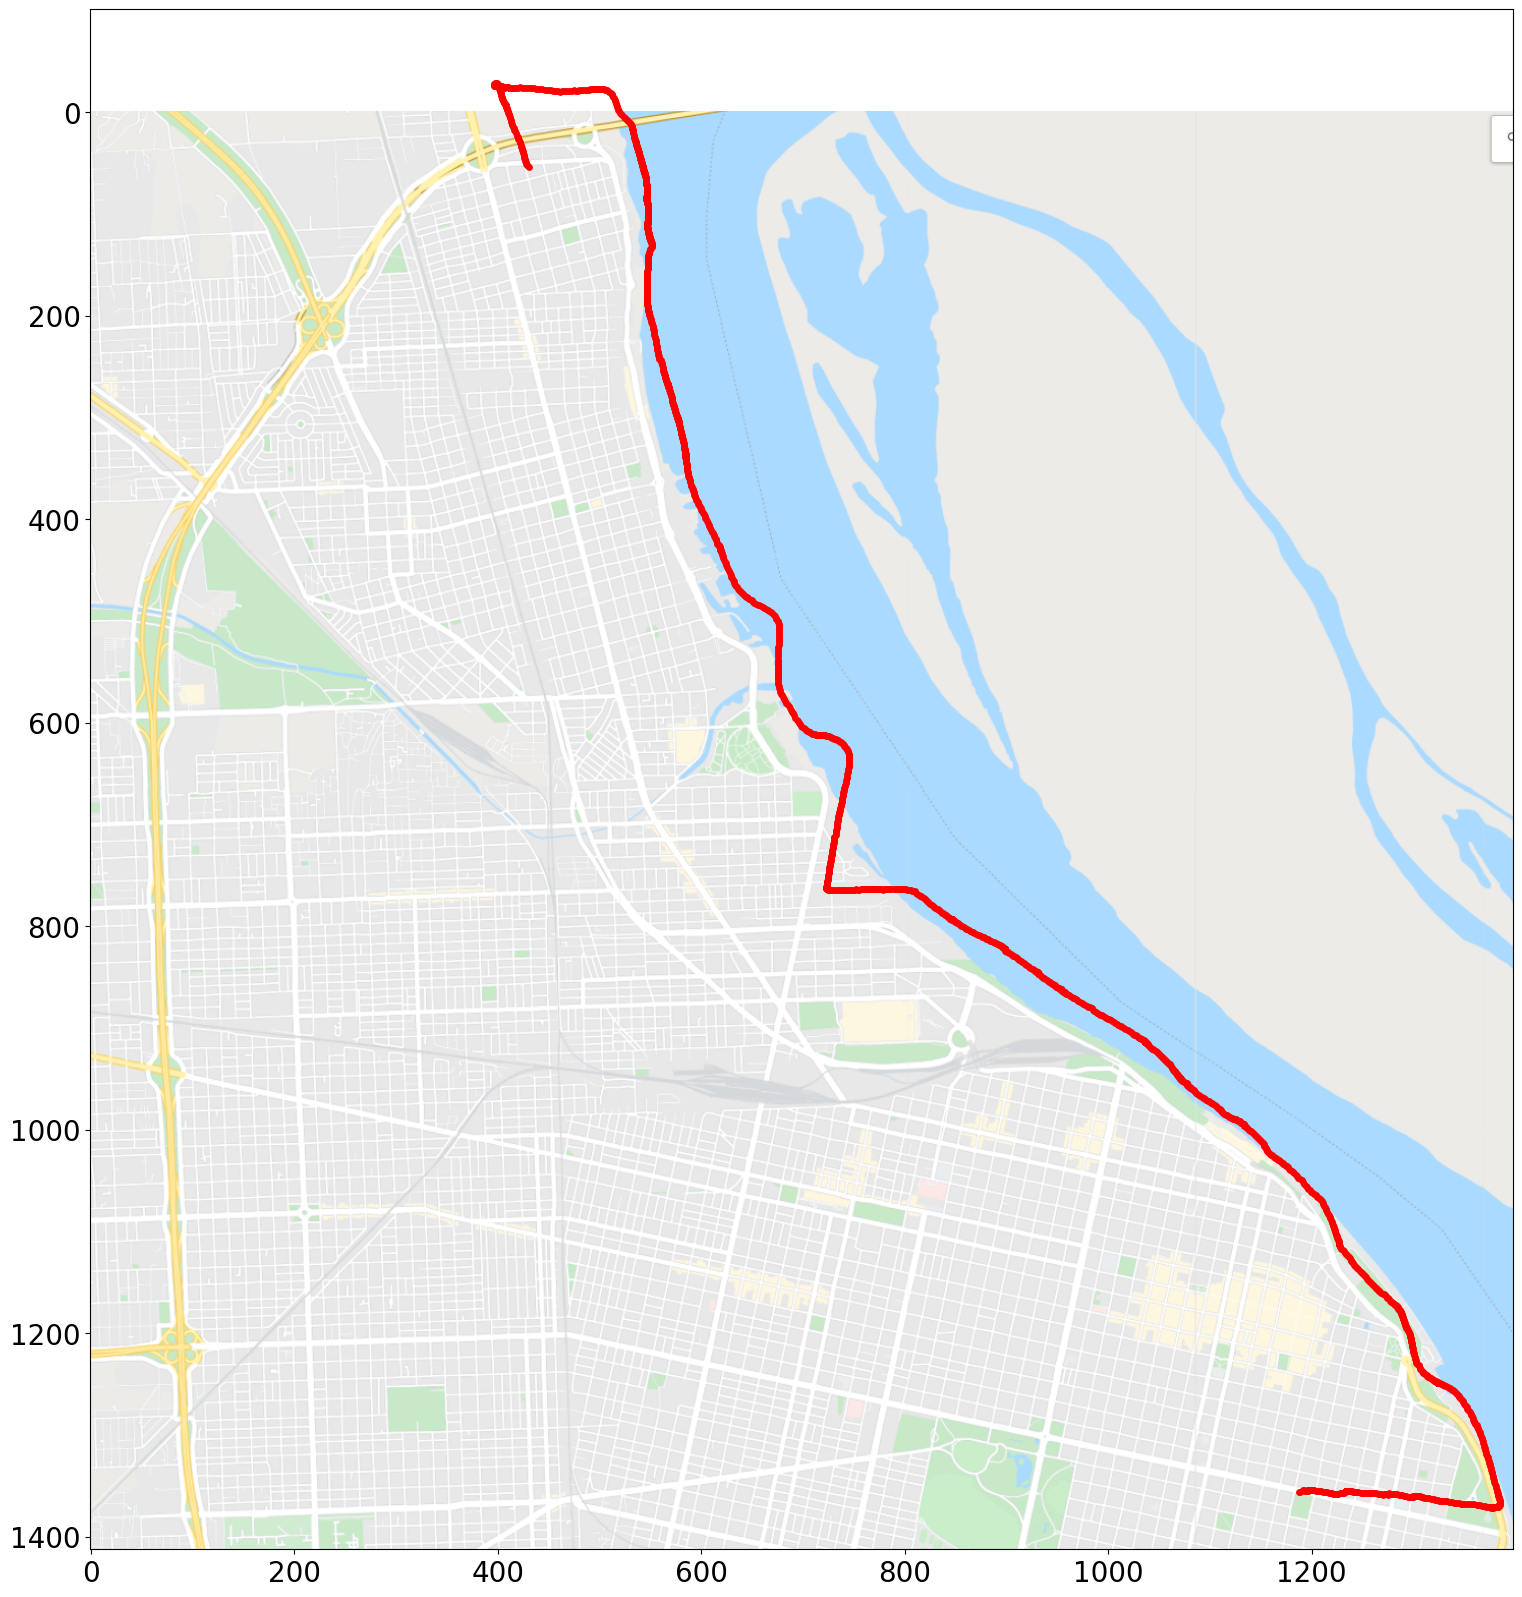

In [471]:
work_map.plot([(lat_append[i],lon_append[i]) for i in range(len(lat_append))])

In [467]:
class my_car():
    
    def __init__(self):
        self.lat = 0.0
        self.lon = 0.0
        self.movement_noise = 0
        self.speed_noise = 0
        self.bearing_noise = 0
        self.x = np.array([[0.], [0.], [0.]]) # State variables [Delta Distance, Speed, Bearing]

        
    def set_values(self, new_lat, new_lon, new_speed, new_bearing):
        self.lat = float(new_lat)
        self.lon = float(new_lon)
        self.position_noise(self.movement_noise)
        self.speed = np.random.normal(new_speed, self.speed_noise, 1)
        self.bearing = np.random.normal(new_bearing, self.bearing_noise, 1)
        
    
    def set_noise(self, new_movement_noise, new_speed_noise, new_bearing_noise):
        self.movement_noise = float(new_movement_noise)
        self.speed_noise = float(new_speed_noise)
        self.bearing_noise = float(new_bearing_noise)
        
        
    def position_noise(self,meters):
        dist=np.random.random()*meters
        angle=np.random.random()*360-180
        self.lat, self.lon = my_map.destinationPoint(self.lat, self.lon, dist, angle)
        
    
    def move(self, measurement, timestep):
        self.update(timestep)
        self.sense(measurement)
        
        
    def predict(self,measurement, timestep):
        self.sense(measurement)
        self.update(timestep)
    
    
    def update(self,timestep):
         # Make Movement
        self.x[0] = self.x[1]  * timestep
        self.lat, self.lon = my_map.destinationPoint(self.lat, self.lon, self.x[0], self.x[2])
        # Apply noise to the movement
        self.position_noise(self.movement_noise)
        
    
    def sense(self,measurement):
        measurement[0] = np.random.normal(measurement[0], self.speed_noise, 1)
        measurement[1] = np.random.normal(measurement[1], self.bearing_noise, 1)
        self.x[2] = measurement[1]
        self.x[1] = measurement[0]

In [468]:
class ParticleFilter():
    
    def __init__(self, work_map, initial_values, J, particles_noise=10):
        self.J = J
        self.particles_number = []
        self.center_lat = []
        self.center_lon = []
        self.radius_estimate = []
        self.work_map = work_map
        self.particles_noise = particles_noise
        
        self.particles=[]
        for i in range(J):
            ford_fiesta = my_car()
            ford_fiesta.set_noise(0,0,0)
            ford_fiesta.set_values(initial_values['Latitude'] ,
                                   initial_values['Longitude'], 
                                   0,
                                   0)
            ford_fiesta.position_noise(self.particles_noise)
            self.particles.append(ford_fiesta)
            
            
    def run(self, measurements, timestep):
        for step,measurement in measurements.iterrows():
            if ((step%timestep)==0):            
                sensors_measurement = np.array([[measurement['Speed']], [measurement['Bearing']]])
                wt = np.zeros(len(self.particles))
    
                for i in range(len(self.particles)):
                    self.particles[i].predict(sensors_measurement,timestep)
                    coord = [[self.particles[i].lat, self.particles[i].lon]]
                    wt[i] =self.work_map.get_policy_prob(coord)[0]     # Calculo de probabilidad de partículas
        
                new_particles = [self.particles[idx[0]] for idx in np.argwhere(wt>0)] #delete imposible positions
                self.particles = new_particles
                wt = wt[wt>0]
            
                self.particles_number.append(len(self.particles))
                
                #Append center and radius
                temp_center_lat=0
                temp_center_lon=0
                for i in range(len(self.particles)):
                    temp_center_lat += (self.particles[i].lat/len(self.particles))
                    temp_center_lon += (self.particles[i].lon/len(self.particles))
                self.center_lat.append(temp_center_lat)
                self.center_lon.append(temp_center_lon)

                max_temp_radius = 0
                for i in range(len(self.particles)):
                    temp_radius=my_map.haversine(temp_center_lat,temp_center_lon,self.particles[i].lat,self.particles[i].lon)
                    max_tem_radius = max(max_temp_radius, temp_radius)
                self.radius_estimate.append(max_tem_radius)

                self.particles = ParticleFilter.resampling_wheel(self.particles,wt, self.J, self.particles_noise)
                self.particles_number.append(len(self.particles))

        
    @staticmethod
    def resampling_wheel(list_particles, weights, J, particles_noise):
        new_list_particles = []
        wheel = np.cumsum(weights) / np.sum(weights)
        for i in range(J):
            rand_value = np.random.random()
            index = np.argmax(wheel>rand_value)
            new_list_particles.append(copy.deepcopy(list_particles[index]))
            # El resampling agrega ruido en la posición de las particulas para aumentar la probabilidad 
            # de tener partículas correctas
            new_list_particles[-1].position_noise(particles_noise)
        return new_list_particles

In [469]:
myParticleFilter = ParticleFilter(work_map, route_1.iloc[0], 1000, 50)
myParticleFilter.run(route_1,10)

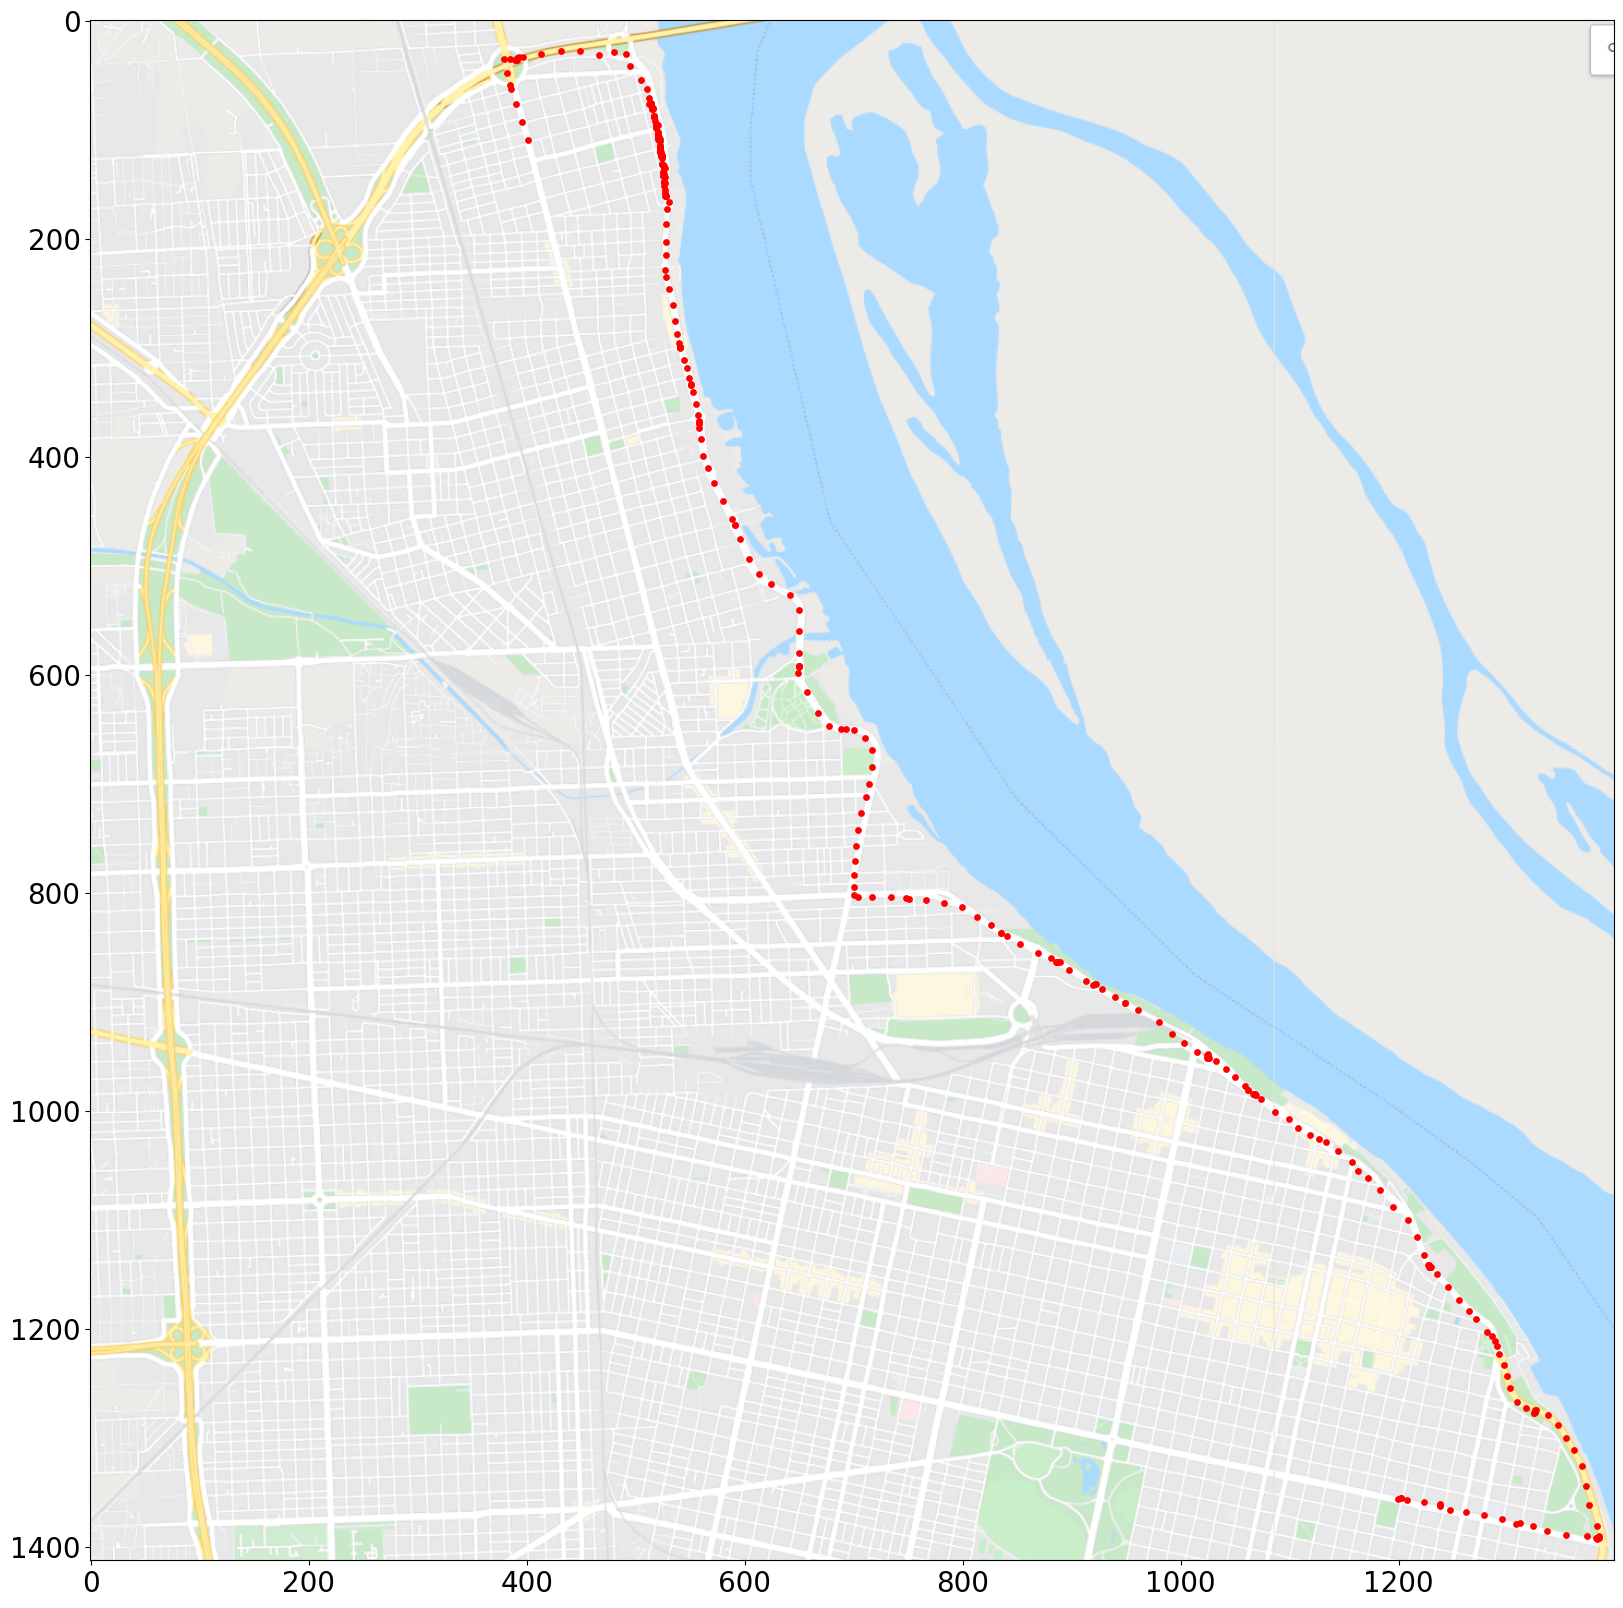

In [470]:
work_map.plot([(myParticleFilter.center_lat[i],myParticleFilter.center_lon[i]) for i in 
               range(len(myParticleFilter.center_lat)-1)])